In [104]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, jaccard_score, roc_curve, confusion_matrix, classification_report, auc, RocCurveDisplay, f1_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from fastai.tabular.all import *
import pickle

In [105]:
sample_sub = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train_dataset.csv")
test = pd.read_csv("test_dataset.csv")
print(sample_sub.shape, train.shape, test.shape)

(4000, 2) (10000, 24) (4000, 23)


In [106]:
train.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,...,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,...,4,5,2,5,3,5,4,0,10.0,0


In [107]:
train.isnull().sum()

id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             28
satisfaction                          0
dtype: int64

In [108]:
train = train.dropna(subset='Arrival Delay in Minutes')

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9972 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 9972 non-null   int64  
 1   Gender                             9972 non-null   object 
 2   Customer Type                      9972 non-null   object 
 3   Age                                9972 non-null   int64  
 4   Type of Travel                     9972 non-null   object 
 5   Class                              9972 non-null   object 
 6   Flight Distance                    9972 non-null   int64  
 7   Inflight wifi service              9972 non-null   int64  
 8   Departure/Arrival time convenient  9972 non-null   int64  
 9   Ease of Online booking             9972 non-null   int64  
 10  Gate location                      9972 non-null   int64  
 11  Food and drink                     9972 non-null   int64  
 1

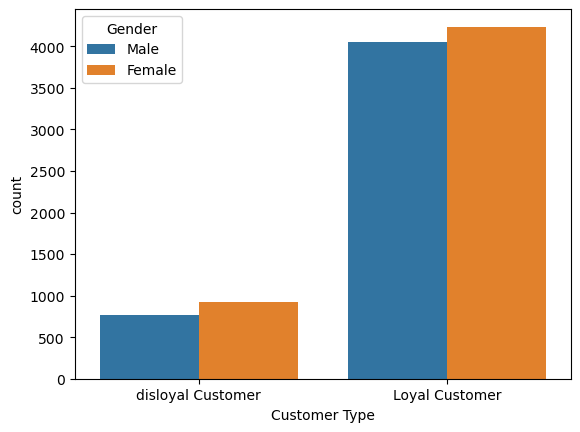

In [110]:
sns.countplot(data=train, x='Customer Type', hue='Gender')
plt.show()

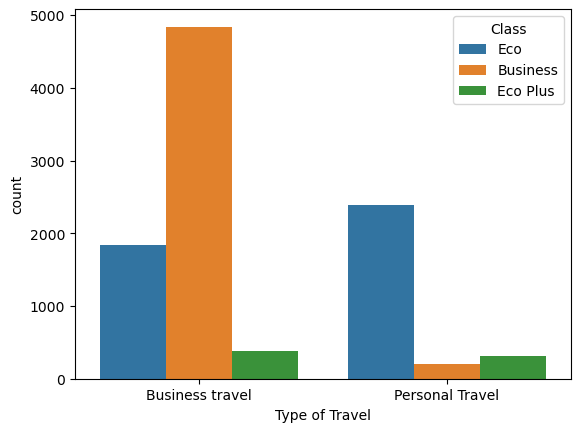

In [111]:
sns.countplot(data=train, x='Type of Travel', hue='Class')
plt.show()

In [112]:
train.head(1)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0


In [113]:
print(train.Gender.unique())
print(train['Customer Type'].unique())
print(train['Type of Travel'].unique())
print(train['Class'].unique())

['Male' 'Female']
['disloyal Customer' 'Loyal Customer']
['Business travel' 'Personal Travel']
['Eco' 'Business' 'Eco Plus']


In [114]:
def prepared(df):
    
    gender = {'Female': 0, 'Male': 1}
    df['Gender'] = df['Gender'].map(gender)
    
    customer_type = {'disloyal Customer': 0, 'Loyal Customer': 1}
    df['Customer Type'] = df['Customer Type'].map(customer_type)
    
    type_travel =  {'Business travel': 0, 'Personal Travel': 1}
    df['Type of Travel'] = df['Type of Travel'].map(type_travel)
    
    type_class =  {'Eco': 0, 'Business': 1, 'Eco Plus': 2}
    df['Class'] = df['Class'].map(type_class)
    
    df.drop('id', axis=1, inplace=True)
    
    std_scaler = StandardScaler()
    df = std_scaler.fit_transform(df)
    
    return df

In [115]:
X = train.drop('satisfaction', axis=1)
y = train[['satisfaction']]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [117]:
y_train.head()

,satisfaction
537,1
813,1
5324,0
2162,1
7698,1


In [118]:
X_train = prepared(X_train)

In [119]:
X_train

array([[ 1.04029994, -2.20089892, -1.16285669, ...,  0.52141881,
        -0.30726494, -0.33691783],
       [-0.96126123,  0.4543598 , -0.76010508, ...,  0.52141881,
        -0.35577517, -0.36095176],
       [-0.96126123,  0.4543598 , -0.89435562, ..., -0.99881432,
        -0.35577517, -0.36095176],
       ...,
       [ 1.04029994,  0.4543598 , -0.89435562, ...,  0.52141881,
        -0.35577517, -0.36095176],
       [-0.96126123,  0.4543598 , -1.83410936, ...,  1.28153537,
        -0.21024447, -0.36095176],
       [-0.96126123,  0.4543598 ,  0.17964866, ...,  1.28153537,
         0.22634765, -0.04851074]])

In [120]:
X_test = prepared(X_test)

In [121]:
X_test

array([[ 1.01464355,  0.44033609,  0.30043535, ...,  1.31089217,
        -0.40573112,  0.01585712],
       [ 1.01464355,  0.44033609, -0.77829314, ..., -1.78130988,
        -0.31170569, -0.25659711],
       [ 1.01464355,  0.44033609, -0.9131342 , ...,  0.53784166,
        -0.09231302, -0.40796057],
       ...,
       [ 1.01464355,  0.44033609,  0.23301482, ...,  1.31089217,
        -0.40573112, -0.13550634],
       [-0.98556779,  0.44033609,  1.24432278, ..., -0.23520885,
        -0.40573112, -0.40796057],
       [-0.98556779,  0.44033609,  0.03075322, ...,  0.53784166,
        -0.40573112, -0.40796057]])

ACCURACY: 0.8721804511278195
JACCARD: 0.7692307692307693
ALL REPORTS:               precision    recall  f1-score   support

           0       0.86      0.89      0.87       998
           1       0.89      0.85      0.87       997

    accuracy                           0.87      1995
   macro avg       0.87      0.87      0.87      1995
weighted avg       0.87      0.87      0.87      1995



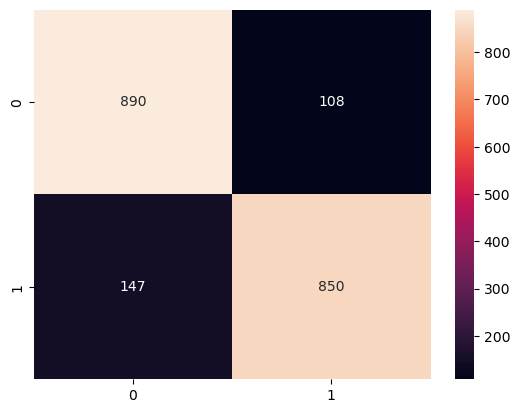

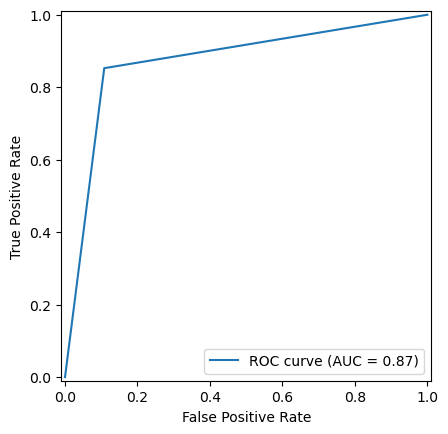

In [122]:
LOG_model = LogisticRegressionCV()
LOG_model.fit(X_train, y_train.values.ravel())

predict = LOG_model.predict(X_test)

print(f"ACCURACY: {accuracy_score(y_test, predict)}")
print(f"JACCARD: {jaccard_score(y_test, predict)}")
print(f"ALL REPORTS: {classification_report(y_test, predict)}")

sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='g')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="ROC curve")
display.plot()
plt.show()

ACCURACY: 0.9077694235588972
JACCARD: 0.8257575757575758
ALL REPORTS:               precision    recall  f1-score   support

           0       0.88      0.94      0.91       998
           1       0.94      0.87      0.90       997

    accuracy                           0.91      1995
   macro avg       0.91      0.91      0.91      1995
weighted avg       0.91      0.91      0.91      1995



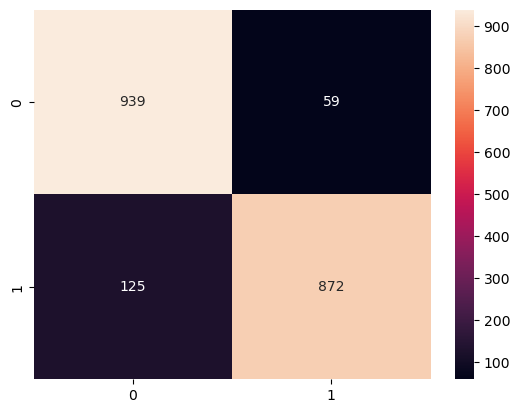

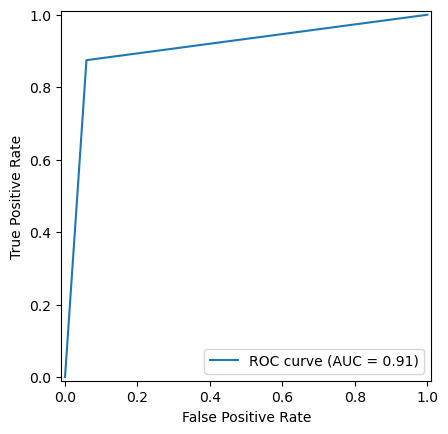

In [123]:
KNN_model = KNeighborsClassifier(n_neighbors=9)
KNN_model.fit(X_train, y_train.values.ravel())

predict = KNN_model.predict(X_test)

print(f"ACCURACY: {accuracy_score(y_test, predict)}")
print(f"JACCARD: {jaccard_score(y_test, predict)}")
print(f"ALL REPORTS: {classification_report(y_test, predict)}")

sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='g')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="ROC curve")
display.plot()
plt.show()

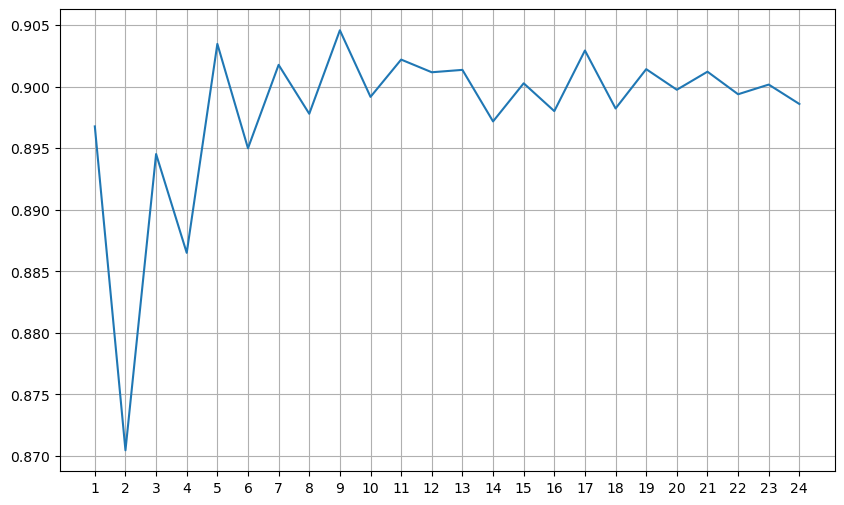

In [124]:
f1 = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k) # k-ni qiymati
    knn.fit(X_train, y_train.values.ravel())
    y_predict = knn.predict(X_test)
    f1.append(f1_score(y_test, y_predict))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),f1)
plt.xticks(range(1,25))
plt.grid()
plt.show()

ACCURACY: 0.9373433583959899
JACCARD: 0.8804971319311663
ALL REPORTS:               precision    recall  f1-score   support

           0       0.93      0.95      0.94       998
           1       0.95      0.92      0.94       997

    accuracy                           0.94      1995
   macro avg       0.94      0.94      0.94      1995
weighted avg       0.94      0.94      0.94      1995



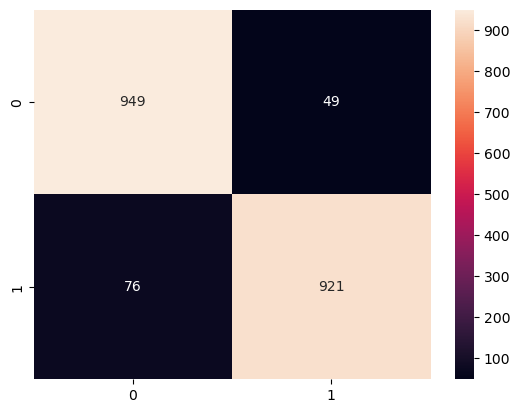

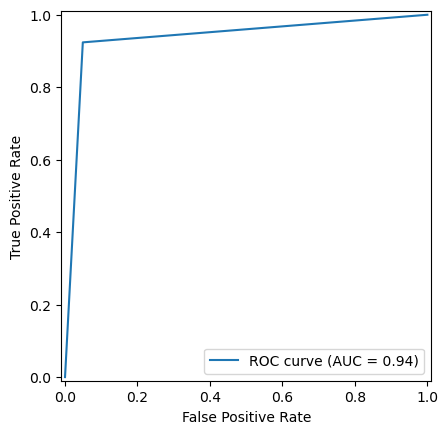

In [125]:
SVM_model = SVC()
SVM_model.fit(X_train, y_train.values.ravel())

predict = SVM_model.predict(X_test)

print(f"ACCURACY: {accuracy_score(y_test, predict)}")
print(f"JACCARD: {jaccard_score(y_test, predict)}")
print(f"ALL REPORTS: {classification_report(y_test, predict)}")

sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='g')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="ROC curve")
display.plot()
plt.show()


ACCURACY: 0.9308270676691729
JACCARD: 0.8680688336520076
ALL REPORTS:               precision    recall  f1-score   support

           0       0.91      0.95      0.93       998
           1       0.95      0.91      0.93       997

    accuracy                           0.93      1995
   macro avg       0.93      0.93      0.93      1995
weighted avg       0.93      0.93      0.93      1995



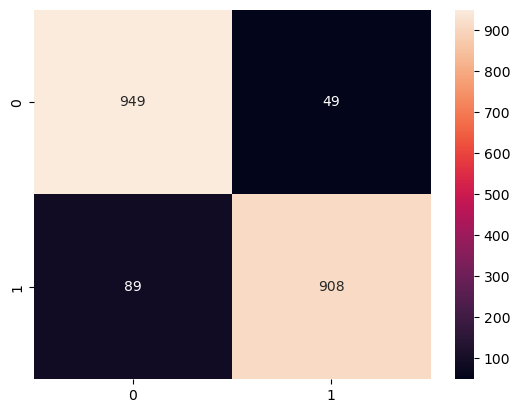

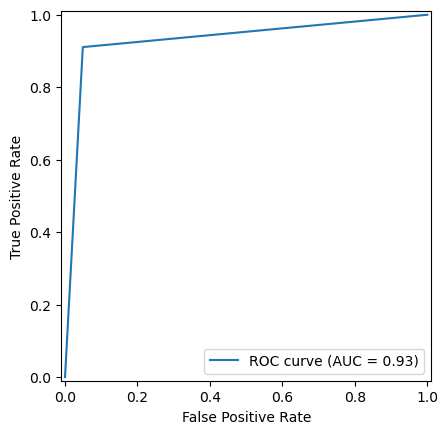

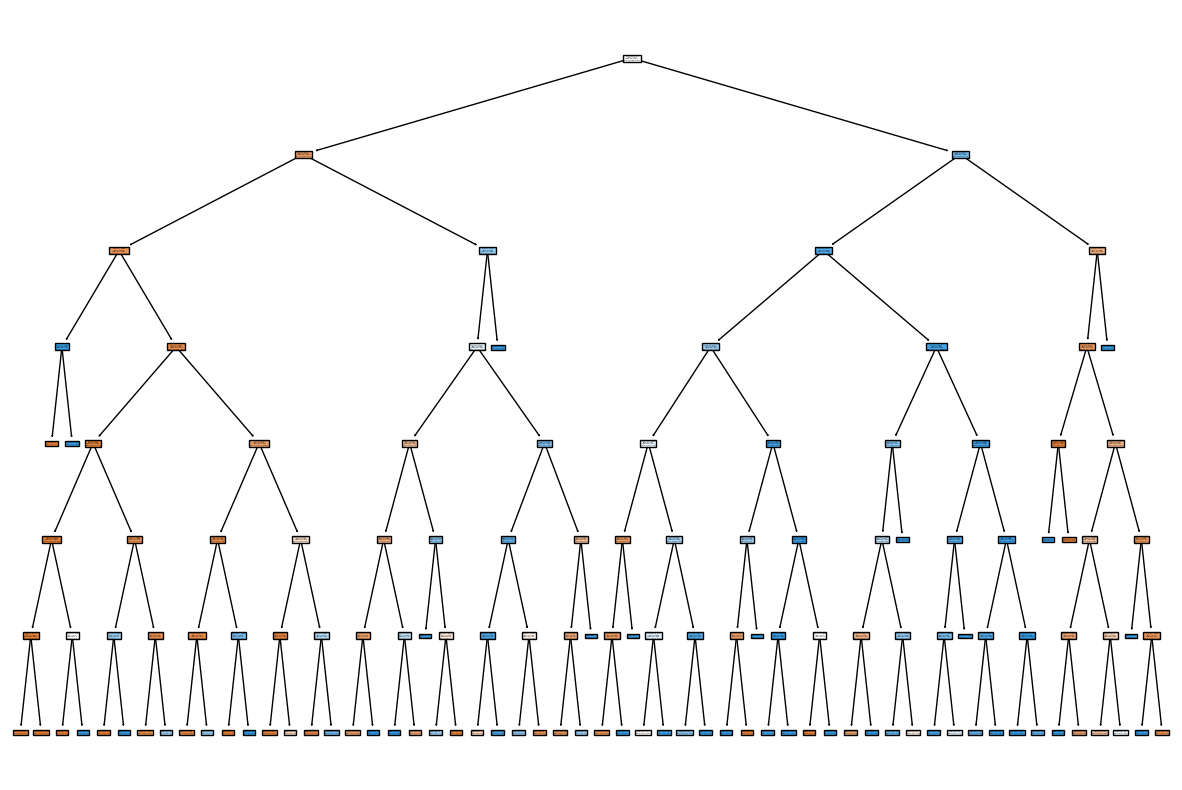

In [126]:
Tree_model = DecisionTreeClassifier(max_depth=7)
Tree_model.fit(X_train, y_train.values.ravel())

predict = Tree_model.predict(X_test)

print(f"ACCURACY: {accuracy_score(y_test, predict)}")
print(f"JACCARD: {jaccard_score(y_test, predict)}")
print(f"ALL REPORTS: {classification_report(y_test, predict)}")

sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='g')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="ROC curve")
display.plot()
plt.show()

#cols = df.drop('Drug', axis=1).columns
#classes = df['Drug'].unique()

plt.figure(figsize=(15,10))
tree.plot_tree(Tree_model, filled=True)
plt.show()

ACCURACY: 0.949874686716792
JACCARD: 0.9041227229146692
ALL REPORTS:               precision    recall  f1-score   support

           0       0.95      0.95      0.95       998
           1       0.95      0.95      0.95       997

    accuracy                           0.95      1995
   macro avg       0.95      0.95      0.95      1995
weighted avg       0.95      0.95      0.95      1995



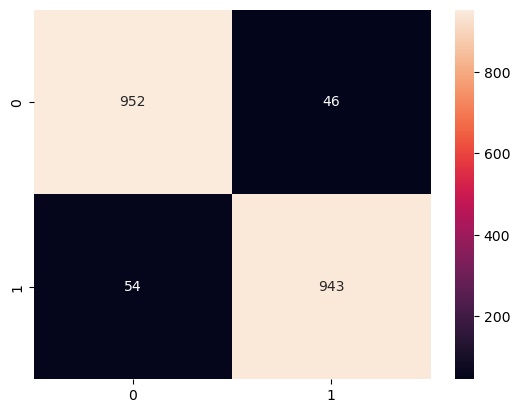

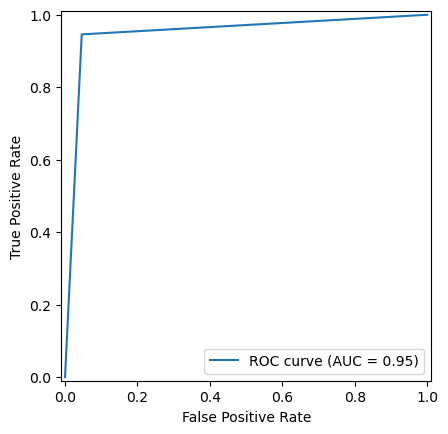

In [81]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train.values.ravel())

predict = RF_model.predict(X_test)

print(f"ACCURACY: {accuracy_score(y_test, predict)}")
print(f"JACCARD: {jaccard_score(y_test, predict)}")
print(f"ALL REPORTS: {classification_report(y_test, predict)}")

sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='g')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="ROC curve")
display.plot()
plt.show()

In [83]:
path = 'train_dataset.csv'
df = pd.read_csv("train_dataset.csv")
df.head(1)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0


In [85]:
df.drop('id', axis=1, inplace=True)

In [86]:
df.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [89]:
dls = TabularDataLoaders.from_csv("train_dataset.csv", path=path, bs=64, y_names='satisfaction', 
                    cat_names=['Gender', 'Customer Type', 'Type of Travel', 'Class'],
                    count_names=['Age', 'Flight Distance', 'Inflight wifi service',
                    'Departure/Arrival time convenient', 'Ease of Online booking',
                    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
                    'Inflight entertainment', 'On-board service', 'Leg room service',
                    'Baggage handling', 'Checkin service', 'Inflight service',
                    'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
                    procs=[Categorify, FillMissing, Normalize])

c:\Users\MAGISTR\anaconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [90]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.374306,0.226237,0.481000,00:00
1,0.119468,0.085644,0.481000,00:00
2,0.074050,0.069951,0.481000,00:00
3,0.060199,0.064660,0.481000,00:00
4,0.059661,0.064281,0.481000,00:00


In [100]:
test = pd.read_csv('test_dataset.csv')
test.head(1)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,Female,Loyal Customer,25,Personal Travel,Eco,2704,2,2,2,...,5,2,4,4,3,5,1,5,152,191.0


In [127]:
test = prepared(test)

In [128]:
test

array([[-1.00652126,  0.47485808, -1.00949875, ...,  1.25053935,
         3.89350692,  4.93599285],
       [-1.00652126,  0.47485808,  0.61798677, ..., -0.26503629,
         1.30036771,  1.0562469 ],
       [ 0.99352099,  0.47485808,  0.75361056, ...,  0.49275153,
        -0.39081004, -0.39516885],
       ...,
       [ 0.99352099,  0.47485808, -0.1279441 , ..., -1.02282411,
         0.25747477,  0.86086401],
       [ 0.99352099,  0.47485808, -1.14512254, ...,  1.25053935,
        -0.39081004, -0.39516885],
       [-1.00652126, -2.10589235, -1.00949875, ..., -1.78061193,
         2.59693732,  2.56348634]])

In [130]:
prediction = RF_model.predict(test)

In [132]:
sample_sub['satisfaction'] = prediction

In [133]:
sample_sub.to_csv("submission.csv", index=False)

In [134]:
sample_sub.head()

,id,satisfaction
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
